In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, zero_one_loss, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from collections import Counter

In [2]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional\bank-additional.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
print(df.shape)

(4119, 20)


In [3]:
#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
df_encoded = pd.get_dummies(df['job'], prefix='job', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['job']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [4]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)

In [5]:
# ss = StandardScaler()
# X_train_ss = ss.fit_transform(train_features)
# X_test_ss = ss.transform(test_features)

# niet genormaliseerd
X_train_ss = train_features
X_test_ss = test_features

In [6]:
estimators = [10, 50, 100, 200, 500] 
max_depths = [3, 6, 10, 15, 20] 

grid_values = {'n_estimators': estimators, 'max_depth':max_depths}

# grid_values = enables searching over any sequence of parameter settings
# scoring = strategy to evaluate the performance of the cross-validated model on the test set
# n_jobs = number of jobs to run in parallel. None means 1. -1 means using all processors.
# verbose = controls the verbosity: the higher, the more messages. 
    # >1 : the computation time for each fold and parameter candidate is displayed; 
    # >2 : the score is also displayed; 
    # >3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
# cv = determines the cross-validation splitting strategy. Possible inputs for cv are:
    # none : to use the default 5-fold cross validation;
    # integer : to specify the number of folds in a (Stratified)KFold,
# return_train_score = if False, the cv_results_ attribute will not include training scores

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring='roc_auc', n_jobs=-1, verbose=10, cv=10, return_train_score=True)
clf.fit(X_train_ss, train_targets) # run fit with all sets of parameters
best_n_estimators_value = clf.best_params_['n_estimators']
best_max_depth_value = clf.best_params_['max_depth']
best_score = clf.best_score_ 

print(clf.best_estimator_)
clf_predictions = clf.predict(X_test_ss)
print(confusion_matrix(test_targets, clf_predictions))
print(classification_report(test_targets,clf_predictions))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
RandomForestClassifier(max_depth=10, n_estimators=500)
[[708   7]
 [ 82  27]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       715
           1       0.79      0.25      0.38       109

    accuracy                           0.89       824
   macro avg       0.85      0.62      0.66       824
weighted avg       0.88      0.89      0.87       824



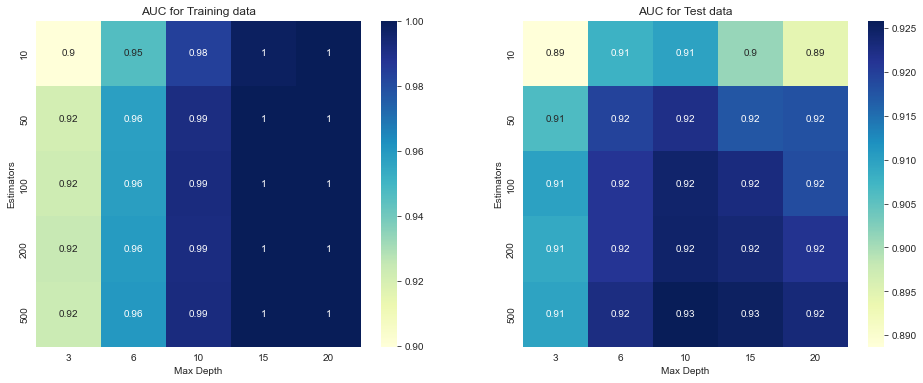

In [7]:
# plot the heatmap of AUC values for all possible combinations of n_estimators and max_depth values
# two heatmaps : one for train data and another for test data
max_depth_list = list(clf.cv_results_['param_max_depth'].data)
estimators_list = list(clf.cv_results_['param_n_estimators'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Training data')
plt.subplot(1,2,2)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Test data')
plt.show()

In [8]:
def plot_roc_curve(roc_auc_train, roc_auc_test):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

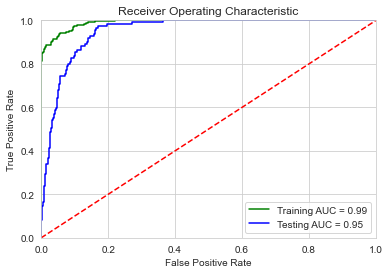

In [9]:
# make a Random Forest Classifier with the best values of the hyperparameters
# then plot the ROC curve

#Best hyper parameter 
clf = RandomForestClassifier(n_estimators=best_n_estimators_value, max_depth=best_max_depth_value)
clf.fit(X_train_ss, train_targets)

y_pred_train = clf.predict_proba(X_train_ss)[:,1]
y_pred_test = clf.predict_proba(X_test_ss)[:,1]

   
#train data ROC
fpr_tr, tpr_tr, threshold = roc_curve(train_targets, y_pred_train)
roc_auc_train = auc(fpr_tr, tpr_tr)

#test data ROC
fpr_ts, tpr_ts, threshold = roc_curve(test_targets, y_pred_test)
roc_auc_test = auc(fpr_ts, tpr_ts)

#Plot ROC curve
plot_roc_curve(roc_auc_train, roc_auc_test)

In [10]:
acc_rf_grid = accuracy_score(test_targets, clf.predict(X_test_ss))

print(acc_rf_grid)

0.8944174757281553


In [11]:
# Compare both the models using Prettytable library    
x = PrettyTable()

x.field_names = ["Model", "n_estimators", "max_depth","Accuracy"]

x.add_row(["Random Forest with GridSearch", best_n_estimators_value, best_max_depth_value, acc_rf_grid])

print(x)

+-------------------------------+--------------+-----------+--------------------+
|             Model             | n_estimators | max_depth |      Accuracy      |
+-------------------------------+--------------+-----------+--------------------+
| Random Forest with GridSearch |     500      |     10    | 0.8944174757281553 |
+-------------------------------+--------------+-----------+--------------------+


>1, train: 0.964, test: 0.893
>2, train: 0.963, test: 0.893
>3, train: 0.967, test: 0.891
>4, train: 0.966, test: 0.897
>5, train: 0.967, test: 0.893
>6, train: 0.965, test: 0.892
>7, train: 0.965, test: 0.892
>8, train: 0.965, test: 0.894
>9, train: 0.965, test: 0.894
>10, train: 0.966, test: 0.893
>11, train: 0.966, test: 0.893
>12, train: 0.966, test: 0.894
>13, train: 0.966, test: 0.892
>14, train: 0.965, test: 0.893
>15, train: 0.966, test: 0.893
>16, train: 0.966, test: 0.893
>17, train: 0.967, test: 0.894
>18, train: 0.965, test: 0.893
>19, train: 0.968, test: 0.892


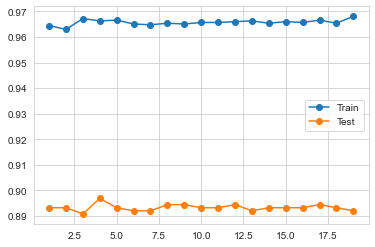

In [12]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 20)]

for i in values:
	# configure the model
	model = RandomForestClassifier(n_estimators=best_n_estimators_value, max_depth=best_max_depth_value).fit(
        train_features, train_targets)
	# evaluate on the train dataset
	schatting = model.predict(train_features)
	train_acc = accuracy_score(train_targets, schatting)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_schatting = model.predict(test_features)
	test_acc = accuracy_score(test_targets, test_schatting)
	test_scores.append(test_acc)
	# summarise progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()